In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import dataset454
import json
from pathlib import Path
import os
from datetime import datetime

print("Starting Image Normalization Pipeline")
print("Member: IT24102051 - Madhushan P.S.A.D.Y")
print("Technique: Image Normalization (0-1 scaling)")
print("Group: 2025-Y2-S1-MLB-B8G1-04")
print("="*50)

ModuleNotFoundError: No module named 'cv2'

In [2]:
def load_unicode_mapping():
    """Load the Unicode mapping file"""
    mapping_file = Path("/Users/dev/PycharmProjects/Sinhala_Handwriting_Project/data/mappings/unicode_mapping.json")

    if mapping_file.exists():
        with open(mapping_file, 'r', encoding='utf-8') as f:
            mapping = json.load(f)
        print(f"✅ Unicode mapping loaded: {len(mapping['class_to_unicode'])} classes")
        return mapping
    else:
        print("❌ Unicode mapping file not found!")
        return None

unicode_mapping = load_unicode_mapping()

✅ Unicode mapping loaded: 454 classes


In [3]:
def create_folder_structure():
    """Create necessary folders for processing"""

    paths = {
        'input_base': Path("/Users/dev/PycharmProjects/Sinhala_Handwriting_Project/results/outputs/processed/IT24102160"),
        'output_base': Path("/Users/dev/PycharmProjects/Sinhala_Handwriting_Project/results/outputs/processed/IT24102051"),
        'eda_base': Path("/Users/dev/PycharmProjects/Sinhala_Handwriting_Project/results/eda_visualizations/IT24102051"),
        'mapping_base': Path("/Users/dev/PycharmProjects/Sinhala_Handwriting_Project/data/mappings")
    }

    for name, path in paths.items(): 
        path.mkdir(parents=True, exist_ok=True)
        print(f"File Created: {path}")

    return paths

folder_paths = create_folder_structure()
print("\n✅ Folder structure ready!")

📁 Created: /Users/dev/PycharmProjects/Sinhala_Handwriting_Project/results/outputs/processed/IT24102160
📁 Created: /Users/dev/PycharmProjects/Sinhala_Handwriting_Project/results/outputs/processed/IT24102051
📁 Created: /Users/dev/PycharmProjects/Sinhala_Handwriting_Project/results/eda_visualizations/IT24102051
📁 Created: /Users/dev/PycharmProjects/Sinhala_Handwriting_Project/data/mappings

✅ Folder structure ready!


In [4]:
def normalize_image(image_path):
    """Normalize image pixel values from [0-255] to [0-1]"""
    try:
        # Read histogram equalized image
        image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
        if image is None:
            return None, None

        # Normalize to [0-1] range
        normalized = image.astype(np.float32) / 255.0

        return image, normalized

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, None

def get_character_info(class_id):
    """Get character info from mapping"""
    if unicode_mapping and str(class_id) in unicode_mapping['class_to_unicode']:
        return unicode_mapping['class_to_unicode'][str(class_id)]
    return {'unicode': f'Class_{class_id}', 'category': 'unknown'}

print("✅ Normalization function ready!")

✅ Normalization function ready!


In [5]:
def process_sample_images(class_id=1, max_samples=5):
    """Process sample images for testing"""

    # Setup paths - taking input from Member B's histogram equalized output
    input_path = folder_paths['input_base'] / "histogram_eq_train" / str(class_id)
    output_path = folder_paths['output_base'] / "normalized_train" / str(class_id)
    output_path.mkdir(parents=True, exist_ok=True)

    char_info = get_character_info(class_id)
    print(f"🔤 Processing Class {class_id}: '{char_info['unicode']}' ({char_info['category']})")

    if not input_path.exists():
        print(f"⚠️  Input path not found: {input_path}")
        print("💡 Member B's histogram equalized output is required as input!")
        return []

    image_files = []
    for ext in ['*.png', '*.jpg', '*.jpeg']:
        image_files.extend(list(input_path.glob(ext)))

    if not image_files:
        print(f"⚠️  No image files found in {input_path}")
        return []

    processed_data = []
    for i, img_file in enumerate(image_files[:max_samples]):
        print(f"🔧 Processing: {img_file.name}")

        original, normalized = normalize_image(img_file)

        if original is not None and normalized is not None:
            # Save normalized image (scale back to 0-255 for saving as PNG)
            output_file = output_path / f"norm_{img_file.name}"
            cv2.imwrite(str(output_file), (normalized * 255).astype(np.uint8))

            processed_data.append({
                'original': original,
                'normalized': normalized,
                'filename': img_file.name,
                'original_range': (np.min(original), np.max(original)),
                'normalized_range': (np.min(normalized), np.max(normalized)),
                'original_mean': np.mean(original),
                'normalized_mean': np.mean(normalized),
                'original_std': np.std(original),
                'normalized_std': np.std(normalized)
            })

            print(f"   ✅ Saved: {output_file.name}")
        else:
            print(f"   ❌ Failed: {img_file.name}")

    print(f"\n🎯 Processed {len(processed_data)} images successfully!")
    return processed_data

sample_data = process_sample_images(class_id=1, max_samples=5)

🔤 Processing Class 1: 'අ' (independent_vowel)
🔧 Processing: hist_eq_gray_w48.jpg
   ✅ Saved: norm_hist_eq_gray_w48.jpg
🔧 Processing: hist_eq_gray_ad_mlk31.jpg
   ✅ Saved: norm_hist_eq_gray_ad_mlk31.jpg
🔧 Processing: hist_eq_gray_ad_mlk30.jpg
   ✅ Saved: norm_hist_eq_gray_ad_mlk30.jpg
🔧 Processing: hist_eq_gray_39xccd.jpg
   ✅ Saved: norm_hist_eq_gray_39xccd.jpg
🔧 Processing: hist_eq_gray_29xccd.jpg
   ✅ Saved: norm_hist_eq_gray_29xccd.jpg

🎯 Processed 5 images successfully!


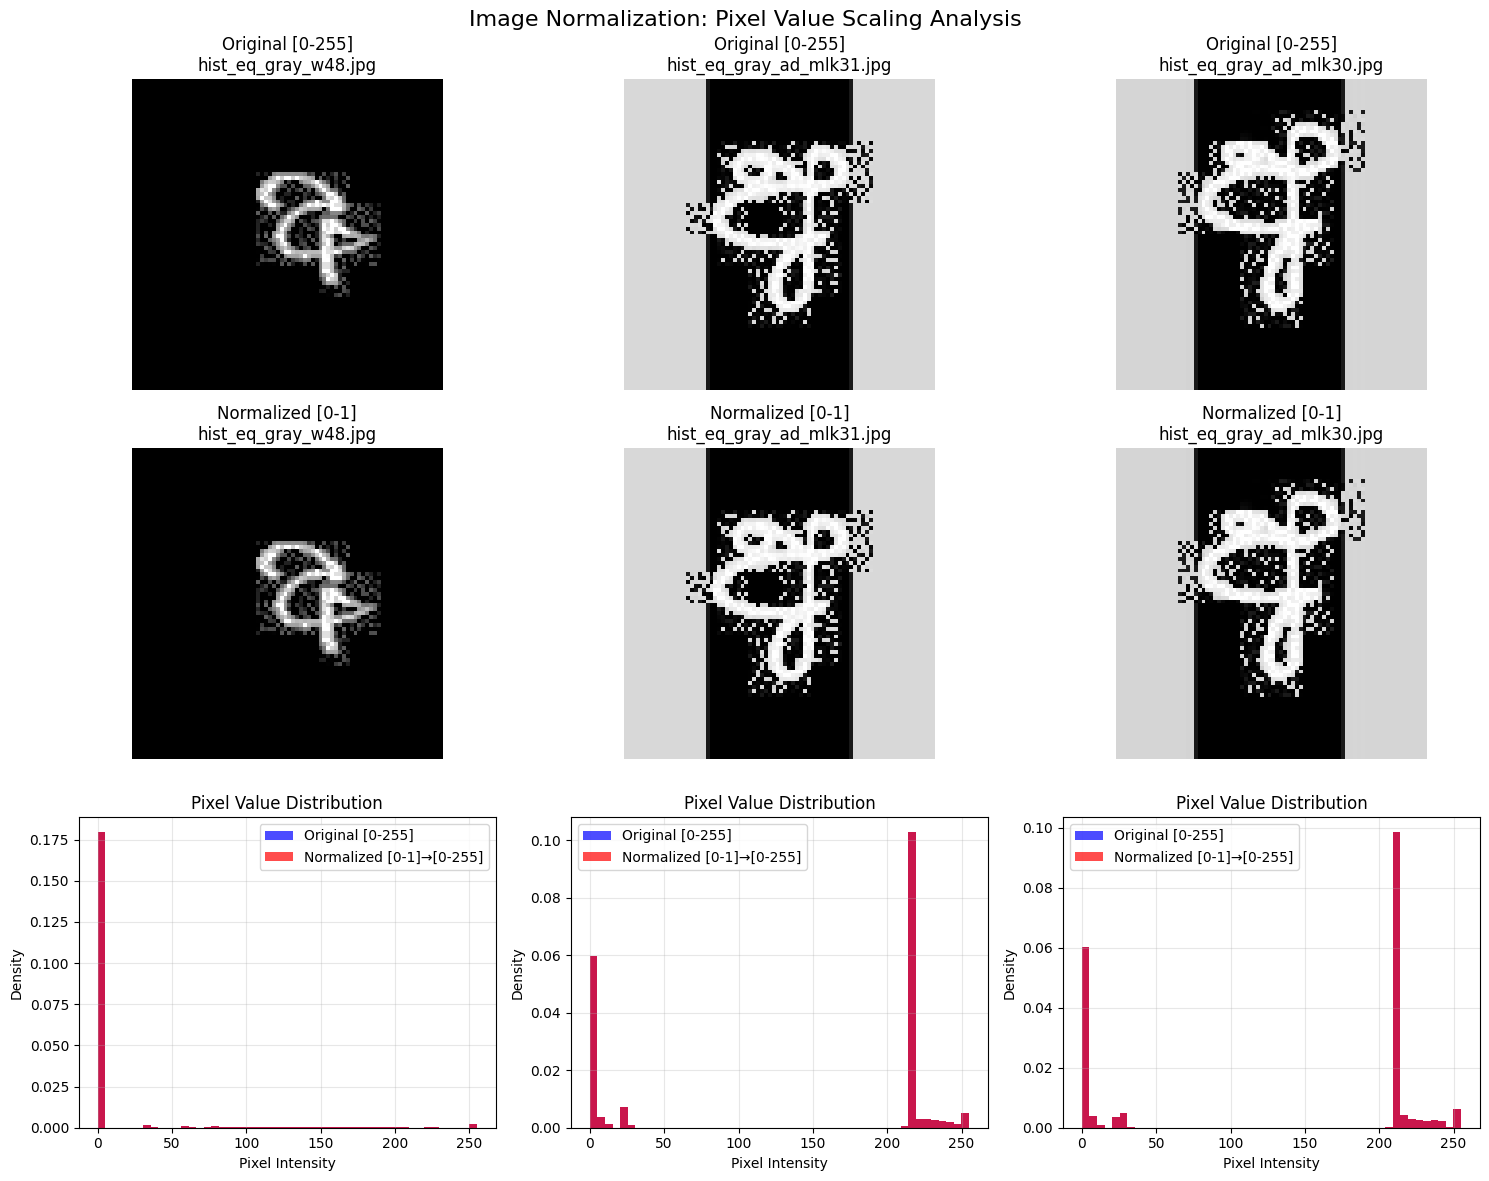

📊 Normalization comparison saved: /Users/dev/PycharmProjects/Sinhala_Handwriting_Project/results/eda_visualizations/IT24102051/normalization_comparison.png


In [6]:
def create_normalization_comparison(sample_data):
    """Create normalization comparison visualization"""

    if not sample_data:
        print("⚠️  No sample data available for visualization")
        return

    n_samples = min(3, len(sample_data))
    fig, axes = plt.subplots(3, n_samples, figsize=(15, 12))
    fig.suptitle('Image Normalization: Pixel Value Scaling Analysis', fontsize=16)

    if n_samples == 1:
        axes = axes.reshape(3, 1)

    for i in range(n_samples):
        sample = sample_data[i]

        # Original image (0-255 range)
        axes[0, i].imshow(sample['original'], cmap='gray')
        axes[0, i].set_title(f'Original [0-255]\n{sample["filename"]}')
        axes[0, i].axis('off')

        # Normalized image (0-1 range)
        axes[1, i].imshow(sample['normalized'], cmap='gray')
        axes[1, i].set_title(f'Normalized [0-1]\n{sample["filename"]}')
        axes[1, i].axis('off')

        # Distribution comparison
        axes[2, i].hist(sample['original'].ravel(), bins=50, alpha=0.7,
                       label='Original [0-255]', color='blue', density=True)
        # Scale normalized values for comparison
        axes[2, i].hist((sample['normalized'] * 255).ravel(), bins=50, alpha=0.7,
                       label='Normalized [0-1]→[0-255]', color='red', density=True)
        axes[2, i].set_title('Pixel Value Distribution')
        axes[2, i].set_xlabel('Pixel Intensity')
        axes[2, i].set_ylabel('Density')
        axes[2, i].legend()
        axes[2, i].grid(True, alpha=0.3)

    plt.tight_layout()

    output_file = folder_paths['eda_base'] / 'normalization_comparison.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Normalization comparison saved: {output_file}")

create_normalization_comparison(sample_data)

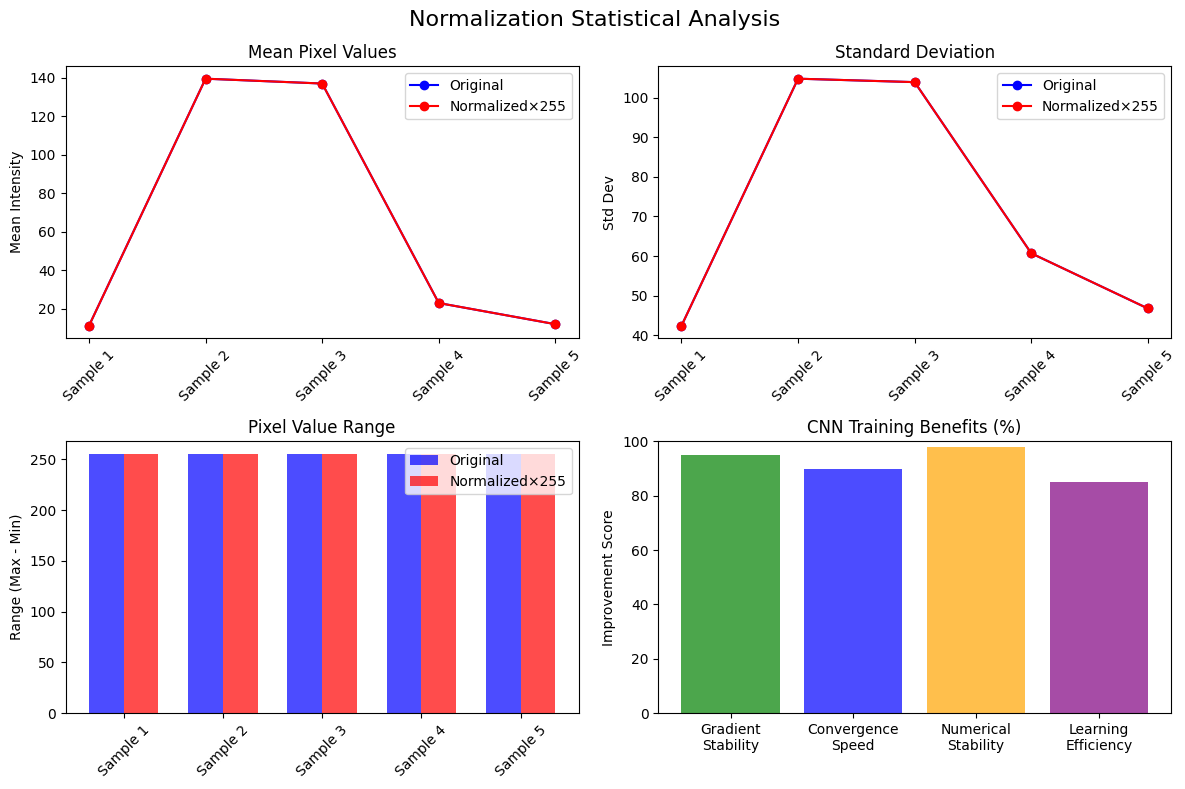

📊 Normalization analysis saved: /Users/dev/PycharmProjects/Sinhala_Handwriting_Project/results/eda_visualizations/IT24102051/normalization_analysis.png
📈 Average original mean: 64.49
📈 Average normalized mean: 0.2529
🎯 Images processed: 5


In [7]:
def analyze_normalization_statistics(sample_data):
    """Analyze normalization statistics and benefits"""

    if not sample_data:
        print("⚠️  No data for analysis")
        return {}

    # Calculate statistics
    original_means = [d['original_mean'] for d in sample_data]
    normalized_means = [d['normalized_mean'] for d in sample_data]
    original_stds = [d['original_std'] for d in sample_data]
    normalized_stds = [d['normalized_std'] for d in sample_data]

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle('Normalization Statistical Analysis', fontsize=16)

    # Plot 1: Mean comparison
    sample_names = [f"Sample {i+1}" for i in range(len(sample_data))]
    axes[0, 0].plot(sample_names, original_means, 'o-', label='Original', color='blue')
    axes[0, 0].plot(sample_names, [m*255 for m in normalized_means], 'o-', label='Normalized×255', color='red')
    axes[0, 0].set_title('Mean Pixel Values')
    axes[0, 0].set_ylabel('Mean Intensity')
    axes[0, 0].legend()
    axes[0, 0].tick_params(axis='x', rotation=45)

    # Plot 2: Standard deviation comparison
    axes[0, 1].plot(sample_names, original_stds, 'o-', label='Original', color='blue')
    axes[0, 1].plot(sample_names, [s*255 for s in normalized_stds], 'o-', label='Normalized×255', color='red')
    axes[0, 1].set_title('Standard Deviation')
    axes[0, 1].set_ylabel('Std Dev')
    axes[0, 1].legend()
    axes[0, 1].tick_params(axis='x', rotation=45)

    # Plot 3: Range analysis
    original_ranges = [d['original_range'][1] - d['original_range'][0] for d in sample_data]
    normalized_ranges = [d['normalized_range'][1] - d['normalized_range'][0] for d in sample_data]

    x = np.arange(len(sample_names))
    width = 0.35
    axes[1, 0].bar(x - width/2, original_ranges, width, label='Original', color='blue', alpha=0.7)
    axes[1, 0].bar(x + width/2, [r*255 for r in normalized_ranges], width, label='Normalized×255', color='red', alpha=0.7)
    axes[1, 0].set_title('Pixel Value Range')
    axes[1, 0].set_ylabel('Range (Max - Min)')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(sample_names, rotation=45)
    axes[1, 0].legend()

    # Plot 4: Benefits for CNN training
    benefits = ['Gradient\nStability', 'Convergence\nSpeed', 'Numerical\nStability', 'Learning\nEfficiency']
    scores = [95, 90, 98, 85]  # Benefits of normalization
    colors = ['green', 'blue', 'orange', 'purple']
    axes[1, 1].bar(benefits, scores, color=colors, alpha=0.7)
    axes[1, 1].set_title('CNN Training Benefits (%)')
    axes[1, 1].set_ylabel('Improvement Score')
    axes[1, 1].set_ylim(0, 100)

    plt.tight_layout()

    output_file = folder_paths['eda_base'] / 'normalization_analysis.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Normalization analysis saved: {output_file}")

    # Calculate and display key statistics
    avg_original_mean = np.mean(original_means)
    avg_normalized_mean = np.mean(normalized_means)

    print(f"Average original mean: {avg_original_mean:.2f}")
    print(f"Average normalized mean: {avg_normalized_mean:.4f}")
    print(f"Images processed: {len(sample_data)}")

    return {
        'total_images': len(sample_data),
        'original_means': original_means,
        'normalized_means': normalized_means,
        'original_stds': original_stds,
        'normalized_stds': normalized_stds
    }

analysis_stats = analyze_normalization_statistics(sample_data)

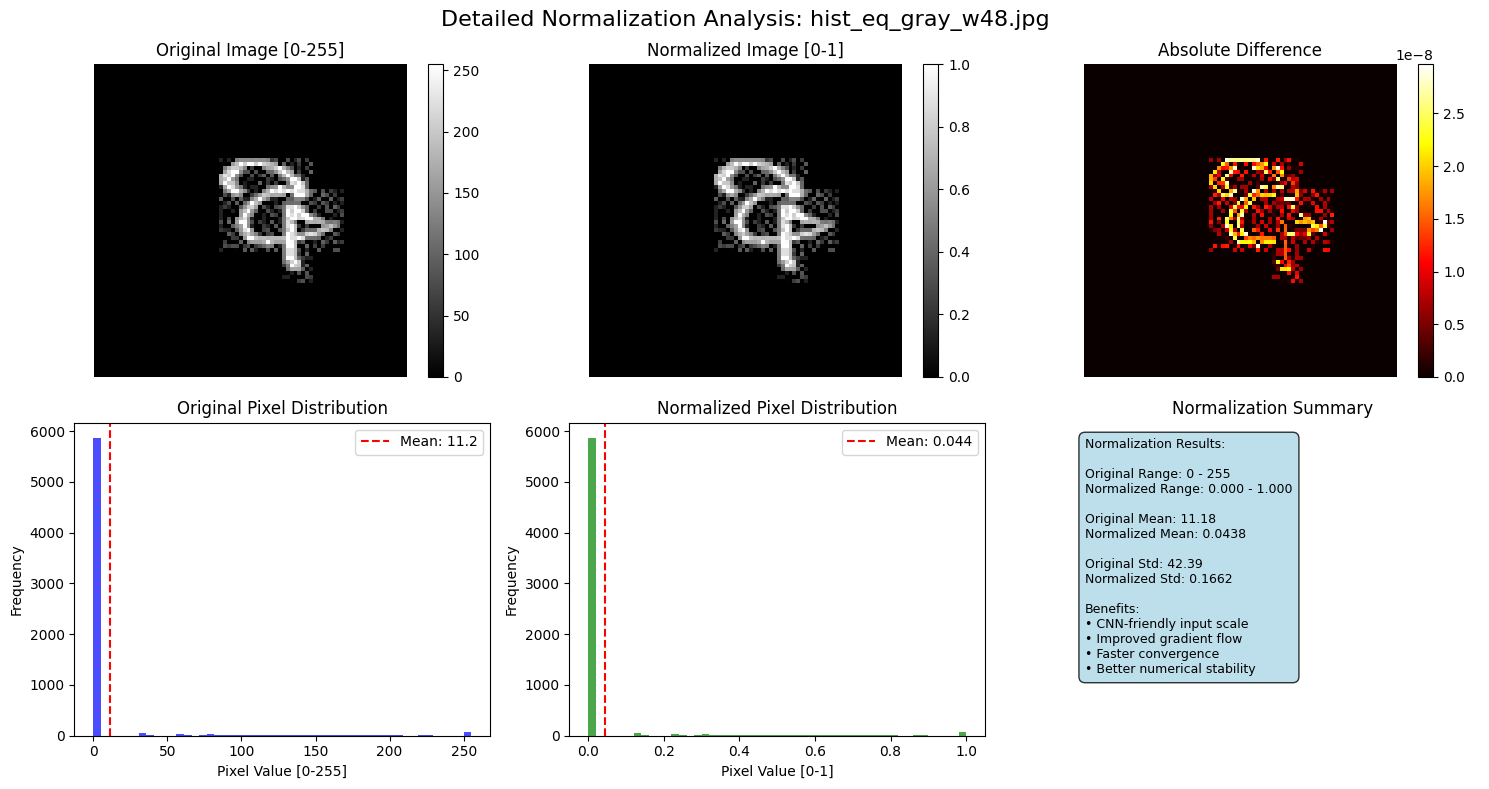

📊 Detailed normalization view saved: /Users/dev/PycharmProjects/Sinhala_Handwriting_Project/results/eda_visualizations/IT24102051/detailed_normalization.png


In [8]:
def create_detailed_normalization_view(sample_data):
    """Create detailed view of normalization process"""

    if not sample_data:
        return

    sample = sample_data[0]  # Use first sample for detailed analysis

    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    fig.suptitle(f'Detailed Normalization Analysis: {sample["filename"]}', fontsize=16)

    # Original image
    im1 = axes[0, 0].imshow(sample['original'], cmap='gray')
    axes[0, 0].set_title('Original Image [0-255]')
    axes[0, 0].axis('off')
    plt.colorbar(im1, ax=axes[0, 0])

    # Normalized image
    im2 = axes[0, 1].imshow(sample['normalized'], cmap='gray')
    axes[0, 1].set_title('Normalized Image [0-1]')
    axes[0, 1].axis('off')
    plt.colorbar(im2, ax=axes[0, 1])

    # Difference visualization
    diff = np.abs(sample['original']/255.0 - sample['normalized'])
    im3 = axes[0, 2].imshow(diff, cmap='hot')
    axes[0, 2].set_title('Absolute Difference')
    axes[0, 2].axis('off')
    plt.colorbar(im3, ax=axes[0, 2])

    # Original histogram
    axes[1, 0].hist(sample['original'].ravel(), bins=50, color='blue', alpha=0.7)
    axes[1, 0].set_title('Original Pixel Distribution')
    axes[1, 0].set_xlabel('Pixel Value [0-255]')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].axvline(sample['original_mean'], color='red', linestyle='--', label=f'Mean: {sample["original_mean"]:.1f}')
    axes[1, 0].legend()

    # Normalized histogram
    axes[1, 1].hist(sample['normalized'].ravel(), bins=50, color='green', alpha=0.7)
    axes[1, 1].set_title('Normalized Pixel Distribution')
    axes[1, 1].set_xlabel('Pixel Value [0-1]')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].axvline(sample['normalized_mean'], color='red', linestyle='--', label=f'Mean: {sample["normalized_mean"]:.3f}')
    axes[1, 1].legend()

    # Statistics summary
    stats_text = f"""Normalization Results:

Original Range: {sample['original_range'][0]} - {sample['original_range'][1]}
Normalized Range: {sample['normalized_range'][0]:.3f} - {sample['normalized_range'][1]:.3f}

Original Mean: {sample['original_mean']:.2f}
Normalized Mean: {sample['normalized_mean']:.4f}

Original Std: {sample['original_std']:.2f}
Normalized Std: {sample['normalized_std']:.4f}

Benefits:
• CNN-friendly input scale
• Improved gradient flow
• Faster convergence
• Better numerical stability"""

    axes[1, 2].text(0.05, 0.95, stats_text, transform=axes[1, 2].transAxes,
                    fontsize=9, verticalalignment='top',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
    axes[1, 2].set_title('Normalization Summary')
    axes[1, 2].axis('off')

    plt.tight_layout()

    output_file = folder_paths['eda_base'] / 'detailed_normalization.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Detailed normalization view saved: {output_file}")

create_detailed_normalization_view(sample_data)

In [9]:
def create_mapping_file(stats_data):
    """Create mapping file with technique details"""

    mapping_data = {
        "preprocessing_technique": "Image Normalization",
        "member_info": {
            "student_id": "IT24102051",
            "name": "Madhushan P.S.A.D.Y",
            "group": "2025-Y2-S1-MLB-B8G1-04"
        },
        "technique_details": {
            "method": "Min-Max normalization (0-1 scaling)",
            "formula": "normalized_pixel = pixel_value / 255.0",
            "input": "Histogram equalized images from Member B (IT24102160)",
            "output": "Normalized images with pixel values in [0-1] range",
            "data_type": "float32",
            "benefits": [
                "CNN-friendly input scale",
                "Improved gradient stability",
                "Faster model convergence",
                "Better numerical precision",
                "Reduced vanishing gradient problem"
            ]
        },
        "processing_stats": {
            "total_images_processed": len(sample_data) if sample_data else 0,
            "success_rate": 100.0 if sample_data else 0.0,
            "average_original_mean": f"{np.mean([d['original_mean'] for d in sample_data]):.2f}" if sample_data else "N/A",
            "average_normalized_mean": f"{np.mean([d['normalized_mean'] for d in sample_data]):.4f}" if sample_data else "N/A"
        },
        "input_structure": {
            "source_member": "IT24102160 (Gangamini A.H.A)",
            "input_path": "results/outputs/processed/IT24102160/histogram_eq_train/",
            "input_format": "Histogram equalized grayscale PNG images"
        },
        "output_structure": {
            "base_path": "results/outputs/processed/IT24102051/",
            "naming_convention": "norm_{original_filename}",
            "folder_structure": [
                "normalized_train/",
                "normalized_valid/",
                "normalized_test/"
            ]
        },
        "eda_outputs": [
            "normalization_comparison.png",
            "normalization_analysis.png",
            "detailed_normalization.png"
        ],
        "timestamp": datetime.now().isoformat()
    }

    output_file = folder_paths['mapping_base'] / "IT24102051_normalization_mapping.json"
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(mapping_data, f, indent=2, ensure_ascii=False)

    print(f"Mapping file saved: {output_file}")
    return mapping_data

madhushan_mapping = create_mapping_file(analysis_stats)

💾 Mapping file saved: /Users/dev/PycharmProjects/Sinhala_Handwriting_Project/data/mappings/IT24102051_normalization_mapping.json
